## STEP 1. 형태소 분석기를 이용하여 품사에 따라 해당 단어를 추출하기

- 명사만 추출 `nouns.txt`
- 명사, 동사 추출 `nouns_verbs.txt`
- 명사, 동사, 형용사 추출 `nouns_verbs_adjectives.txt`

In [36]:
# 시간이 오래 소요되므로 파일로 저장
# word2vec 생성을 위한 토큰화
import os
from konlpy.tag import Okt
from tqdm import tqdm

okt = Okt()
input_file_path = os.getenv('HOME') + '/aiffel/weat/synopsis.txt'
output_file_path = './tokenized/nouns.txt'

'''
with open(input_file_path, 'r', encoding='utf-8') as rf:
    with open(output_file_path, 'w', encoding='utf-8') as wf:
        lines = rf.readlines()
        for line in tqdm(lines):
            words = okt.pos(line, stem=True, norm=True)
            res = [w[0] for w in words if w[1] == "Noun" or w[1] == "Verb"]
            wf.write(' '.join(res) + '\n')
'''

'\nwith open(input_file_path, \'r\', encoding=\'utf-8\') as rf:\n    with open(output_file_path, \'w\', encoding=\'utf-8\') as wf:\n        lines = rf.readlines()\n        for line in tqdm(lines):\n            words = okt.pos(line, stem=True, norm=True)\n            res = [w[0] for w in words if w[1] == "Noun" or w[1] == "Verb"]\n            wf.write(\' \'.join(res) + \'\n\')\n'

In [37]:
# 저장해놓은 토큰 파일 불러오기
tokenized=[]
with open(output_file_path, 'r', encoding='utf-8') as rf:
    for line in rf:
        # 각 줄을 읽어 공백을 기준으로 단어를 나누고 리스트로 변환
        words = line.strip().split()
        tokenized.append(words)

In [38]:
# 개수 세기
cnt=0
for words in tokenized:
    cnt+=len(words)
print(cnt)

1342179


- Noun 개수: 1342179
- Noun & Verb 개수: 1723183
- Noun & Verb & Adjective 개수: 1850315

## STEP 2. 추출된 결과로 embedding model 만들기

In [39]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

[('작품', 0.8846949338912964),
 ('다큐멘터리', 0.8416526913642883),
 ('드라마', 0.8353283405303955),
 ('영화로', 0.814343273639679),
 ('코미디', 0.7921692132949829),
 ('스토리', 0.7879258990287781),
 ('형식', 0.7872180938720703),
 ('주제', 0.7832558751106262),
 ('에마데딘', 0.7752403616905212),
 ('감동', 0.7739428877830505)]

## STEP 3. target, attribute 단어 셋 만들기

In [93]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from konlpy.tag import Okt

# 토큰화 파일 저장 함수
def save_tokens(input_file_name, output_file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+input_file_name, 'r') as fread: 
        with open('./tokenized/'+output_file_name, 'w', encoding='utf-8') as fwrite:
            print(input_file_name, '파일을 읽고 있습니다.')
            lines = fread.readlines()
            for line in tqdm(lines):
                words = okt.pos(line, stem=True, norm=True)
                res = [w[0] for w in words if w[1] == "Noun" or w[1] == "Verb"]
                fwrite.write(' '.join(res) + '\n')
# 토큰 파일 불러오는 함수              
def read_tokens(file_name):
    with open('./tokenized/' + file_name, 'r', encoding='utf-8') as fread:
        # 파일 전체를 읽어서 줄바꿈 문자를 제거하고 하나의 문자열로 반환
        tokenized = fread.read().replace('\n', ' ')
    
    return tokenized

명사만 추출할 때에는 `okt.nouns()`을 활용해보았지만 소요 시간 차이 크지 않았음

In [94]:
# 불용어 불러오기
with open('./stopwords.txt', 'r', encoding='utf-8') as fread:
    stopwords = [line.strip() for line in fread.readlines()]
    print(stopwords)

['하다', '되다', '자신', '위해', '않다', '이다', '되어다', '싶다', '점점', '때문', '오다', '가다', '과연', '이제', '통해', '시작', '영화', '사람', '모두']


stopwords 구성 기준: 모든 데이터셋에서 자주 등장하고, 주제와 관련 없는 단어 선정

In [95]:
# LDA 결과 출력 함수
# 각 주제에 대한 단어 분포 출력
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# 각 문서에서 가장 확률이 큰 주제와 그 확률 출력
def print_max_topic_for_documents(model, documents):
    topic_distribution = model.transform(X)
    max_topic_idxs=[]
    for i, doc in enumerate(documents):
        max_topic_idx = np.argmax(topic_distribution[i])
        max_prob = topic_distribution[i, max_topic_idx]
        print(f"Document #{i}:")
        print(f"Max Probability Topic: {max_topic_idx}, Probability: {max_prob:.4f}")
        print()
        max_topic_idxs.append(max_topic_idx)
    return max_topic_idxs
        
        
def get_topic_words(model, topic_idx, feature_names, n_top_words):
    topic_word_distribution = model.components_[topic_idx]
    top_word_indices = topic_word_distribution.argsort()[:-n_top_words-1:-1]
    top_words = [feature_names[i] for i in top_word_indices]
    top_word_probs = [topic_word_distribution[i] for i in top_word_indices]
    return top_words

### target 단어 추출

In [96]:
# target 데이터 불러오기
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'
# 품사에 따라 바꾸기
output_art_txt = 'synopsis_art_nouns.txt'
output_gen_txt = 'synopsis_gen_nouns.txt'

'''
save_tokens(art_txt, output_art_txt)
save_tokens(gen_txt, output_gen_txt)
'''

art=read_tokens(output_art_txt)
gen=read_tokens(output_gen_txt)

In [97]:
# 벡터화, 불용어 제거
vec_type = 'tfidf'

# TF-IDF
if vec_type=='tfidf':
    vectorizer = TfidfVectorizer(stop_words=stopwords)
# DTM
elif vec_type=='dtm':
    vectorizer = CountVectorizer(stop_words=stopwords)
    
X = vectorizer.fit_transform([art,gen])

In [98]:
m1 = X[0].tocoo()   # sparse matrix를 가져오기
m2 = X[1].tocoo()   # sparse matrix를 가져오기

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 높은 순으로 정렬
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 높은 순으로 정렬 

w1_, w2_ = [], []
print('예술영화를 대표하는 단어들:')
for i in range(100):
    word = vectorizer.get_feature_names()[w1[i][0]]
    print(word, end=', ')
    w1_.append(word)

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    word = vectorizer.get_feature_names()[w2[i][0]]
    print(word, end=', ')
    w2_.append(word)

예술영화를 대표하는 단어들:
그녀, 사랑, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 남편, 감독, 여행, 인생, 발견, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 위기, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 청년, 한국, 가지, 상처, 할머니, 목숨, 이상, 희망, 계획, 매력, 프랑스, 

일반영화를 대표하는 단어들:
그녀, 영화제, 국제, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 여성, 죽음, 인간, 생활, 한편, 결혼, 상황, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 이후, 조직, 회사, 보고, 부산, 아빠, 부부, 일본, 문제, 처음, 그것, 

> Q. 왜 두 문서 사이에 중복값이 많을까?(하다, 되다, 그녀, 자신, 위해 등)  
> A. 둘 다 영화를 다루고 있으므로 공통된 어휘가 많이 사용됨. 또한 현재 문서가 2개만 존재하므로 단어 간의 IDF 값 차이가 적어져 TF 값이 TF-IDF 값에 영향을 끼치는 정도가 커짐

#### TF-IDF/DTM 그대로 활용

In [99]:
# 중복 제거
n = 15
duplicated = set()
# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    else: duplicated.add(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    else: duplicated.add(w2_[i])
    if len(target_gen) == n: break

In [100]:
print('예술영화를 대표하는 단어들:')
for word in target_art:
    print(word, end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for word in target_gen:
    print(word, end=', ')

예술영화를 대표하는 단어들:
음악, 결심, 운명, 지금, 여인, 이름, 준비, 감정, 만난, 충격, 누구, 그린, 연인, 청년, 상처, 

일반영화를 대표하는 단어들:
서울, 애니메이션, 여성, 주인공, 대해, 연출, 사회, 다큐멘터리, 부문, 섹스, 바로, 의도, 정체, 조직, 회사, 

#### LDA 적용

In [88]:
# 중복 단어 불용어 리스트에 추가해서 벡터화
lda_stopwords = stopwords + list(duplicated)
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=lda_stopwords)
    
X = tfidf_vectorizer.fit_transform([art,gen])

In [89]:
lda_stopwords

['하다',
 '되다',
 '자신',
 '위해',
 '않다',
 '이다',
 '되어다',
 '싶다',
 '점점',
 '때문',
 '오다',
 '가다',
 '과연',
 '이제',
 '통해',
 '시작',
 '영화',
 '사람',
 '모두',
 '아빠',
 '순간',
 '사실',
 '가장',
 '소년',
 '미국',
 '서로',
 '발견',
 '마지막',
 '작품',
 '단편',
 '남편',
 '이후',
 '위기',
 '가족',
 '모든',
 '다시',
 '일상',
 '생활',
 '소녀',
 '사랑',
 '죽음',
 '사고',
 '생각',
 '친구',
 '하루',
 '마을',
 '비밀',
 '전쟁',
 '이자',
 '국제',
 '결혼',
 '계속',
 '감독',
 '경찰',
 '시간',
 '인간',
 '학교',
 '하나',
 '사이',
 '여행',
 '과거',
 '관계',
 '대한',
 '마음',
 '어머니',
 '아이',
 '세계',
 '아들',
 '가지',
 '살인',
 '기억',
 '영화제',
 '동생',
 '이야기',
 '모습',
 '처음',
 '남자',
 '인생',
 '여자',
 '명의',
 '사건',
 '한국',
 '세상',
 '동안',
 '최고',
 '한편',
 '다른',
 '현실',
 '그녀',
 '아버지',
 '도시',
 '엄마',
 '아내',
 '계획',
 '우리',
 '상황',
 '존재',
 '간다']

In [90]:
X.shape

(2, 41008)

In [91]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=10, 
                                      learning_method='online', 
                                      random_state=777, 
                                      max_iter=10)

lda_model.fit_transform(X)

array([[0.00176621, 0.98410411, 0.00176621, 0.00176621, 0.00176621,
        0.00176621, 0.00176621, 0.00176621, 0.00176621, 0.00176621],
       [0.00172612, 0.98446489, 0.00172612, 0.00172612, 0.00172612,
        0.00172612, 0.00172612, 0.00172613, 0.00172613, 0.00172613]])

In [92]:
# LDA의 결과 토픽과 각 단어의 비중을 출력
n_top_words = 30
tf_feature_names = vectorizer.get_feature_names_out()

print("Topics in LDA model:")
print_top_words(lda_model, tf_feature_names, n_top_words)

print("Document-Topic Distributions:")
documents = [art, gen]
max_topic_idxs = print_max_topic_for_documents(lda_model, documents)

Topics in LDA model:
Topic #0:
클린턴 강혁 한페이 키플링 에스프레소 에리크 혹시 토산 정장 갈수록 메소포타미아 들락 유동근 대리석 리카도 박사 테리야키 별미 조잡 깃털 아네모네 마퀴스 각성 신동미 태수 쿠온 종결 세인 러브송 라이터
Topic #1:
서브 우즈베키스탄 여관 은표 정율성 호쾌 대학가요제 막상 앞가림 이단옆차기 즉흥연주 소녀 그리기 시실리 결손 로맨틱코미디 일기도 막셀 축해 대서 문성근 병조참판 고무 제다이 변수 무속인 연무대 애론 감자 게이트
Topic #2:
벨라도나 꼭두 정어리 경찰관 치외법권 옐키 의무경찰 군첼 셴젠 한의원 무척 슬러그 흑해 가결 날개 대통령선거 이북 정세희 승부조작 폐쇄병원 화련 상과 서푼 꾸르베 추천 시리 몬테카를로 아타루 흥부전 보헤미언
Topic #3:
조승우 연구기관 굿맨 리틀 어니스트 하류 카베 이영애 제조업체 삽시간 쪽잠 갓길 김영남 밀페된 위생 방만 하도급 트럭운전사 눈곱 카탈로그 보나뻬띠 칼리지 안미나 걸스 교육청 재쉬 아낙네 머큐리 하천 전용
Topic #4:
대림 키타 중요성 주체사상 현행범 무당산 밀수 울렁증 공연 임기 비정상 막스 반라 전편 가루타 로즈왈드 독수리 사칭 여인숙 구명회 음악학자 멘트 가변 사뮈 이력 쥐라기 불친절 공군 노포동 민소매
Topic #5:
재아 약육강식 도린 지혜롭 아틀란타 뤄산얼 제철소 오천만 미시간주 뒷이야기 리테쉬 난폭운전 민친현 자두 컨트롤러 부패커넥션 레온 사미족 퀸즈 왕권강화 래그 좌석 양성애 틱낫한 일천 정현우 탐엣더팜 구덩이 석궁 꿀꿀이
Topic #6:
세린 촬영상 의무 고야상 투표소 자탄 지기 위쯔 피오르 김꽃비 인드렉 결정화 이니셔티브 반대파 김자옥 이승헌 민범 민스트렐 옥편 회포 조성 아빌라 구내식당 뇌우 차려 모씨 최희정 파르셀 선학생 이위
Topic #7:
양심선언 평화로움 말리 한구 엉킨 판별 스먀오 머셜 강문 트위들디 병리학 주차 헐벗 이기주의 타협 순수 타칭 정장 반려자 에티엔느 공정 트위그 농포 취향 왕가위 그간 적응 네

중복 단어를 제거해도 문서에 같은 주제가 할당되는 문제는 해결되지 않음 -> LDA 사용 안 함

In [ ]:
target_art = get_topic_words(lda_model, max_topic_idxs[0], tf_feature_names, 15)
target_gen = get_topic_words(lda_model, max_topic_idxs[1], tf_feature_names, 15)

### attribute 단어 추출 

In [101]:
#파일 불러와서 TF-IDF 생성
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']
# 품사에 따라 바꾸기
output_genre_txt = [txt.strip('.txt')+'_nouns.txt' for txt in genre_txt]

genre = []
for file_name, output_file_name in zip(genre_txt, output_genre_txt):
    #save_tokens(file_name, output_file_name)
    genre.append(read_tokens(output_file_name))

In [102]:
# 벡터화, 불용어 제거
# TF-IDF
if vec_type=='tfidf':
    vectorizer = TfidfVectorizer(stop_words=stopwords)
# DTM
elif vec_type=='dtm':
    vectorizer = CountVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(genre)

#### TF-IDF/DTM 그대로 사용

In [103]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 지구, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 
가족: 엄마, 아빠, 가족, 영화제, 친구, 아주르, 아버지, 그녀, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 
공포(호러): 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 사실, 소녀, 하나, 살인, 
기타: 영화제, 국제, 서울, 단편, 이야기, 그녀, 남자, 사랑, 뉴미디어, 페스티벌, 여자, 대한, 독립, 친구, 작품, 
다큐멘터리: 영화제, 다큐, 국제, 다큐멘터리, 이야기, 대한, 감독, 서울, 우리, 세계, 그녀, 여성, 가족, 한국, 작품, 
드라마: 영화제, 그녀, 사랑, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 가족, 단편, 서울, 대한, 아들, 
멜로로맨스: 그녀, 사랑, 남편, 남자, 여자, 친구, 섹스, 마음, 결혼, 서로, 아내, 관계, 부부, 엄마, 아버지, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 토스카, 니웨, 카바, 영화제, 바흐, 페뷔스, 프롤, 모도, 
미스터리: 사건, 그녀, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 아이, 민혁, 사실, 의문, 
범죄: 사건, 경찰, 그녀, 범죄, 조직, 살인, 마약, 형사, 남자, 모든, 살해, 수사, 발견, 한길수, 범인, 
사극: 조선, 신기전, 사랑, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 하선, 전쟁, 윤서, 트로이, 세자, 허균, 
서부극(웨스턴): 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 개릿, 아이, 무법자, 프린트, 마적, 태구, 현상금, 분노, 
성인물(에로): 그녀, 남편, 마사지, 섹스, 관계, 정사, 남자, 여자, 유부녀, 마음, 사랑, 에피소드, 그린, 아내, 다시, 
스릴러: 그녀,

#### LDA 적용

In [ ]:
# LDA
lda_model = LatentDirichletAllocation(n_components=50, 
                                      learning_method='online', 
                                      random_state=777, 
                                      max_iter=10,
                                     doc_topic_prior=0.1)
# 주제 간 중복 줄이기 위해 topic_word_prior 조정 가능
# 문서 간 주제 중복 줄이기 위해 doc_topic_prior 조정 가능

lda_model.fit_transform(X)

In [ ]:
# LDA의 결과 토픽과 각 단어의 비중을 출력
n_top_words = 15
tf_feature_names = vectorizer.get_feature_names_out()

print("Topics in LDA model:")
print_top_words(lda_model, tf_feature_names, n_top_words)

print("Max Probability Topic for Each Document:")
documents = genre
max_topic_idxs = print_max_topic_for_documents(lda_model, documents)

In [ ]:
attributes=[]
for i in range(len(genre_)):
    attributes.append(get_topic_words(lda_model, max_topic_idxs[i], tf_feature_names, 15))

## STEP 4. WEAT score 계산과 시각화

In [104]:
from numpy import dot
from numpy.linalg import norm
# WEAT score function
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b
def weat_score(X, Y, A, B):    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [105]:
# embedding model과 단어 셋으로 WEAT score 구해보기
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)
        
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.53150725
SF 공연 -0.3741411
SF 공포(호러) -0.6745052
SF 기타 0.0978527
SF 다큐멘터리 0.33839515
SF 드라마 -0.48161277
SF 멜로로맨스 -0.8324336
SF 뮤지컬 0.041505575
SF 미스터리 -0.65147555
SF 범죄 0.031059926
SF 사극 -0.638535
SF 서부극(웨스턴) -0.3227293
SF 성인물(에로) -0.6740359
SF 스릴러 -0.51695967
SF 애니메이션 0.2883604
SF 액션 -0.11773561
SF 어드벤처 -1.0487992
SF 전쟁 0.5109637
SF 코미디 -0.73389447
SF 판타지 -0.41827908
가족 공연 0.22990453
가족 공포(호러) -0.099937126
가족 기타 0.70095116
가족 다큐멘터리 0.7739525
가족 드라마 0.0683443
가족 멜로로맨스 -0.79482913
가족 뮤지컬 0.7491461
가족 미스터리 -0.22383226
가족 범죄 0.49459463
가족 사극 0.048398163
가족 서부극(웨스턴) 0.70755816
가족 성인물(에로) -0.54214656
가족 스릴러 -0.09127344
가족 애니메이션 0.83815926
가족 액션 0.46017346
가족 어드벤처 -0.37564352
가족 전쟁 0.86685187
가족 코미디 -0.33659032
가족 판타지 0.38848364
공연 공포(호러) -0.20096704
공연 기타 0.78022087
공연 다큐멘터리 0.7586542
공연 드라마 -0.22273427
공연 멜로로맨스 -0.8388777
공연 뮤지컬 0.9807199
공연 미스터리 -0.28914705
공연 범죄 0.34854808
공연 사극 -0.2561163
공연 서부극(웨스턴) 0.24222052
공연 성인물(에로) -0.6712176
공연 스릴러 -0.18749203
공연 애니메이션 0.84167475
공연 액션 0.

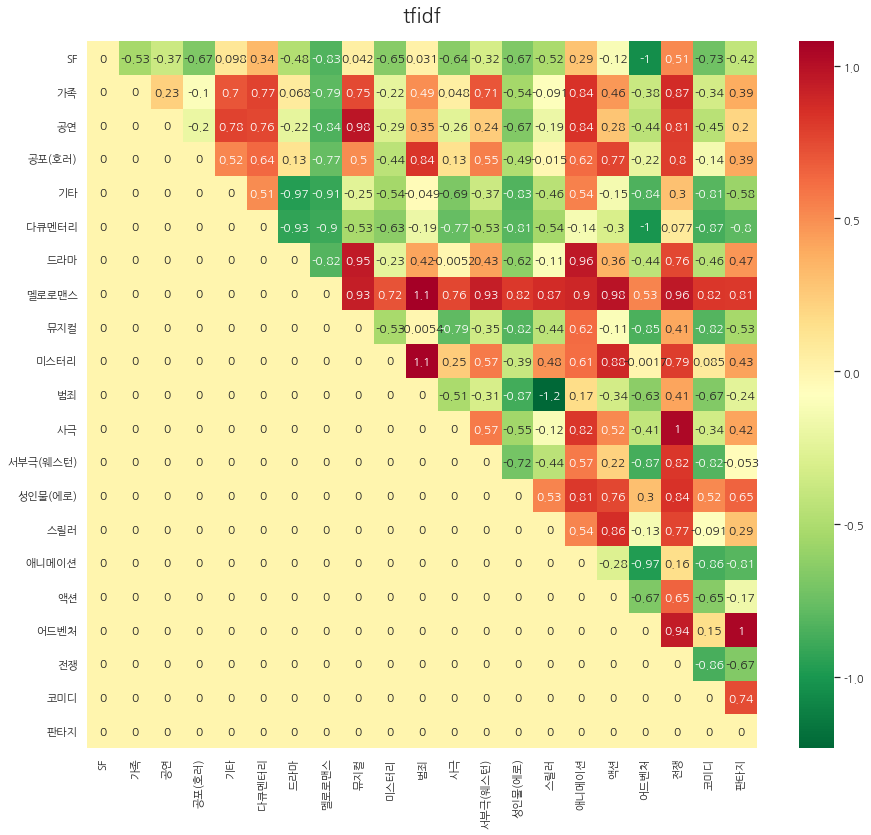

In [106]:
# 시각화
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(matrix, genre_name, title, save=True):
    np.random.seed(0)
    # 한글 지원 폰트
    sns.set(font='NanumGothic')

    # 마이너스 부호 
    plt.rcParams['axes.unicode_minus'] = False

    fig, ax = plt.subplots(figsize=(15,13))
    sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, cmap='RdYlGn_r', ax=ax)

    ax.set_title(title, fontsize=20, pad=20)
    if save:
        plt.savefig('heatmap_'+title+'.png', bbox_inches='tight')

    plt.show()
    
plot_heatmap(matrix, genre_name, 'tfidf', False)